In [166]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [167]:
import numpy as np
import torch

import pandas as pd

from matplotlib import pyplot as plt

import utils, params
from modules import helpers
from modules.nn import pca

import importlib
importlib.reload(utils)
importlib.reload(pca)

<module 'modules.nn.pca' from '/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/nn/pca.py'>

In [168]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [169]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [170]:
print('Higgs:')
mc_higgs = utils.FourLeptonsReader([
    MC_dir + 'higgs2011.csv',
    MC_dir + 'higgs2012.csv'
],scalers=params.scales_higgs)
mc_higgs_dfs = mc_higgs.apply_basic_cuts(mc_higgs.dfs,show_cut_info=True)

print('ZZ:')
mc_zz = utils.FourLeptonsReader([
    MC_dir + 'zzto4mu2011.csv',
    MC_dir + 'zzto2mu2e2011.csv',
    MC_dir + 'zzto4e2011.csv',

    MC_dir + 'zzto4mu2012.csv',
    MC_dir + 'zzto2mu2e2012.csv',
    MC_dir + 'zzto4e2012.csv',
],scalers=params.scales_zz)
mc_zz_dfs = mc_zz.apply_basic_cuts(mc_zz.dfs,show_cut_info=True)

print('Drell-Yan:')
mc_dy = utils.FourLeptonsReader([
    MC_dir + 'dy1050_2011.csv',
    MC_dir + 'dy50_2011.csv',
    MC_dir + 'dy1050_2012.csv',
    MC_dir + 'dy50_2012.csv'
],scalers=params.scales_dy)
mc_dy_dfs = mc_dy.apply_basic_cuts(mc_dy.dfs,show_cut_info=True)

print('tt:')
mc_tt = utils.FourLeptonsReader([
    MC_dir + 'ttbar2011.csv',
    MC_dir + 'ttbar2012.csv'
],scalers=params.scales_tt)
mc_tt_dfs = mc_tt.apply_basic_cuts(mc_tt.dfs,show_cut_info=True)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Leptons cut: 44320 events passed out of 50542 (88%)
 Z cut: 41818 events passed out of 44320 (94%)
 Conservation cut: 39353 events passed out of 40530 (97%)
 Leptons cut: 35855 events passed out of 39353 (91%)
 Z cut: 33996 events passed out of 35855 (95%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Leptons cut: 162016 events passed out of 207439 (78%)
 Z cut: 123286 events passed out of 162016 (76%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Leptons cut: 110224 events passed out of 152367 (72%)
 Z cut: 68099 events passed out of 110224 (62%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Leptons cut: 93161 events passed out of 140811 (66%)
 Z cut: 78064 events passed out of 93161 (84%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Leptons cut: 148678 events passed out of 182153 (82%)
 Z cut: 116017 events passed out of 148678 (78%)
 Conservation cut: 12

In [171]:
bins = np.linspace(50,200,101)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = mc_higgs.get_histogram(mc_higgs_dfs, 'm4l', bins) 
zz_hist = mc_zz.get_histogram(mc_zz_dfs, 'm4l', bins)
dy_hist = mc_dy.get_histogram(mc_dy_dfs, 'm4l', bins)
tt_hist = mc_tt.get_histogram(mc_tt_dfs, 'm4l', bins)

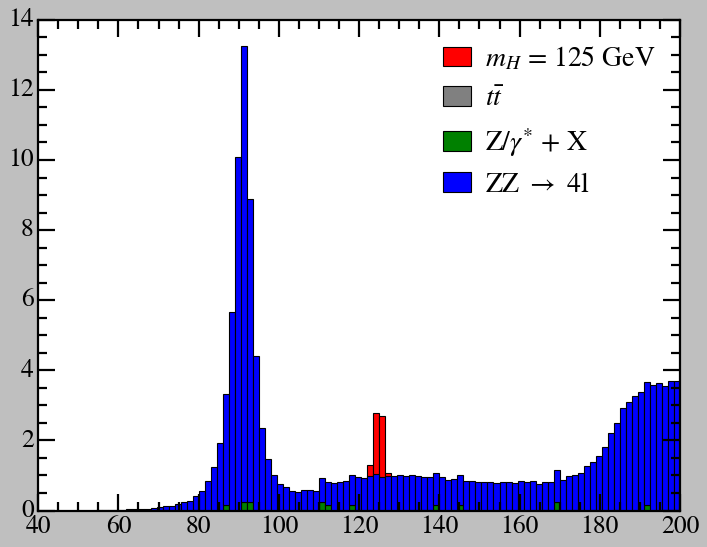

In [172]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [173]:
class FourLeptonsPCA(pca.PCA):
    def __init__(self, dfs, event_nums, fields,
                 higgs_dfs_num=2):
        self.dfs = dfs
        self.event_nums = event_nums
        self.fields = fields

        self.higgs_dfs_num = higgs_dfs_num

    def _subsample(self, df, n):
        idx = np.random.choice(len(df), n, replace=False)
        return df.iloc[idx]
    
    def get_pca(self):
        X = pd.concat([
            self._subsample(df, min(self.event_nums)) for df in self.dfs
        ])[self.fields].to_numpy()

        X = torch.from_numpy(X)

        X_norm, X_mean, X_std = self._standardize(X)
        X_pca, V = self._perform_pca(X_norm)

        higgs_zz_idx = min(self.event_nums) * self.higgs_dfs_num

        higgs_pca = X_pca[:higgs_zz_idx]
        zz_pca = X_pca[higgs_zz_idx:]

        return higgs_pca, zz_pca

In [174]:
mc_all_dfs = mc_higgs_dfs + mc_zz_dfs
mc_all_event_nums = [
    len(df) for df in mc_all_dfs
]

fields = [
    'E1', 'px1', 'py1', 'pz1',
    'E2', 'px2', 'py2', 'pz2',
    'E3', 'px3', 'py3', 'pz3',
    'E4', 'px4', 'py4', 'pz4',
]

mc_all_pca = FourLeptonsPCA(mc_all_dfs, mc_all_event_nums, fields)
higgs_pca, zz_pca = mc_all_pca.get_pca()

PC 1


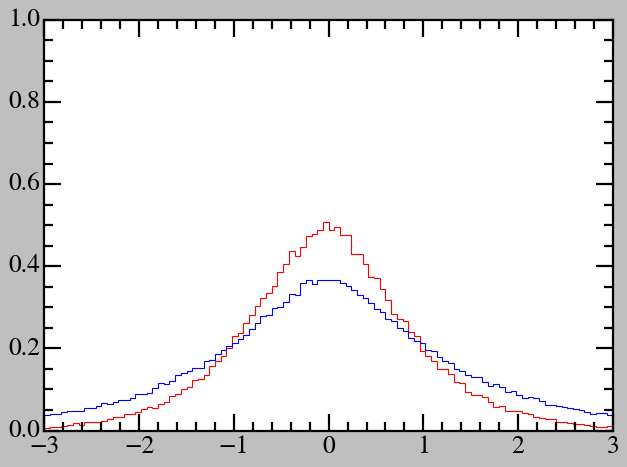

PC 2


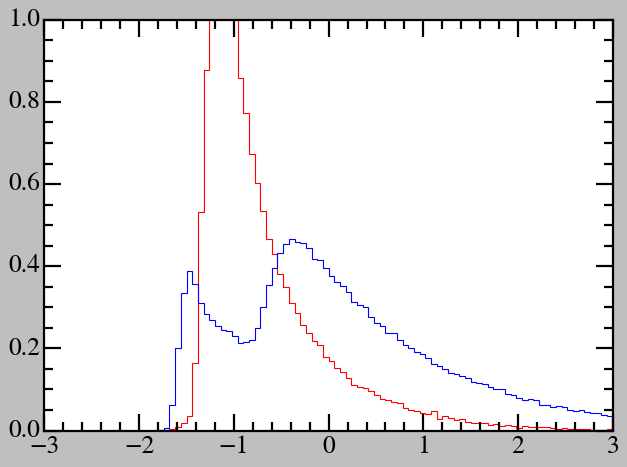

PC 3


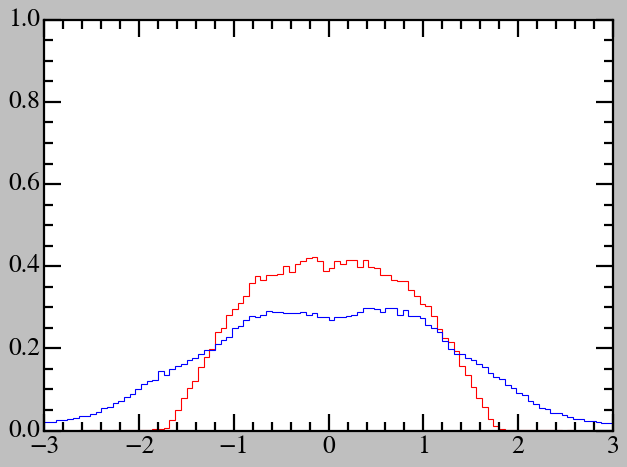

PC 4


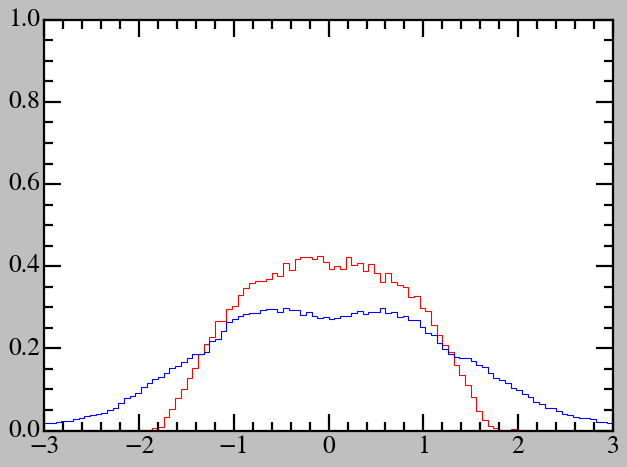

PC 5


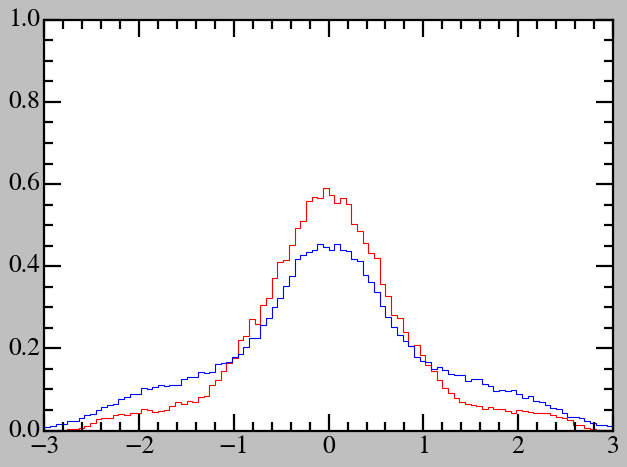

PC 6


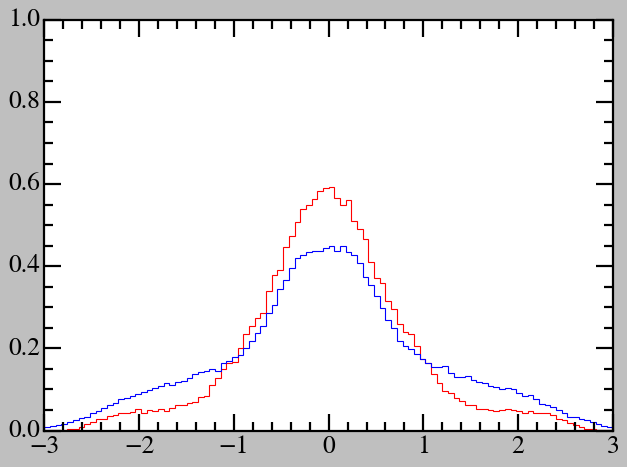

PC 7


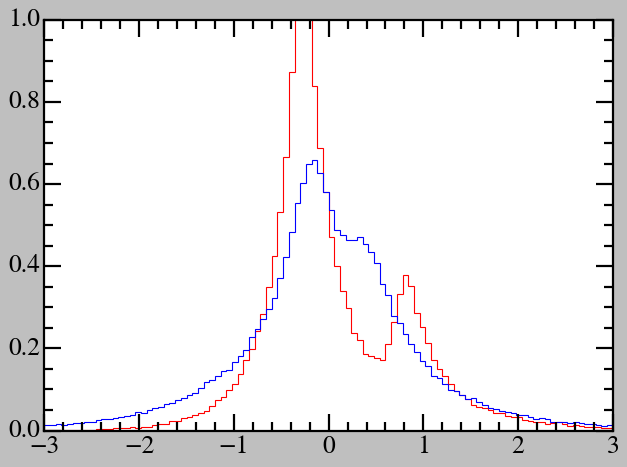

PC 8


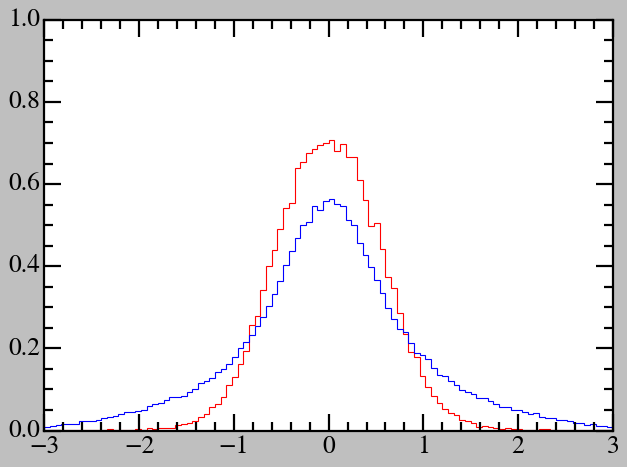

PC 9


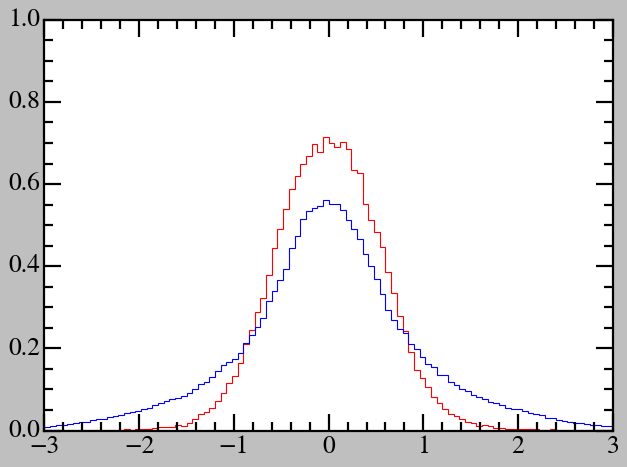

PC 10


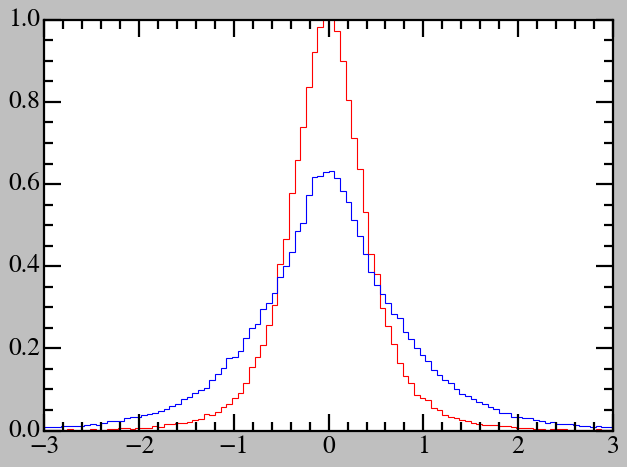

PC 11


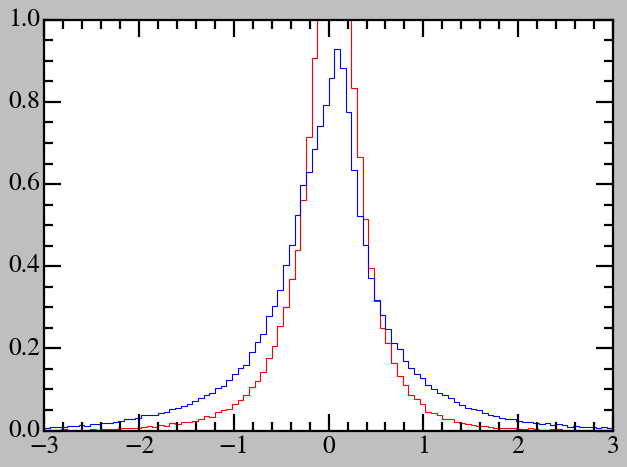

PC 12


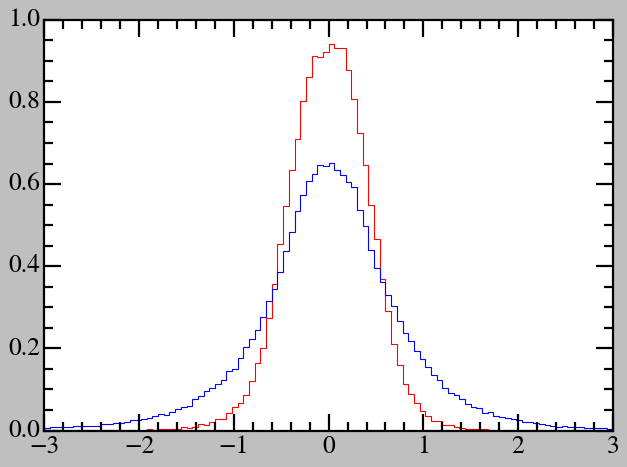

PC 13


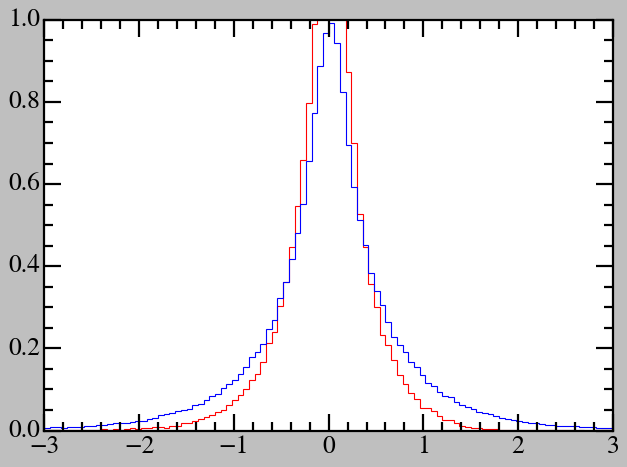

PC 14


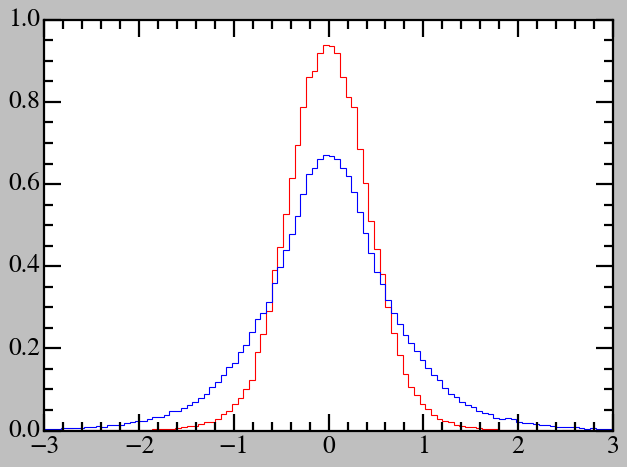

PC 15


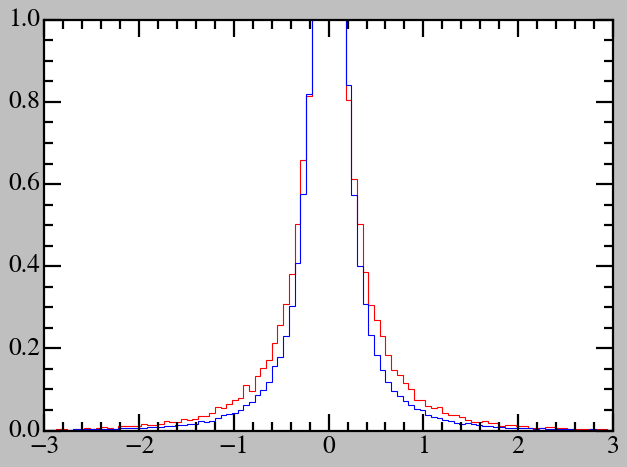

PC 16


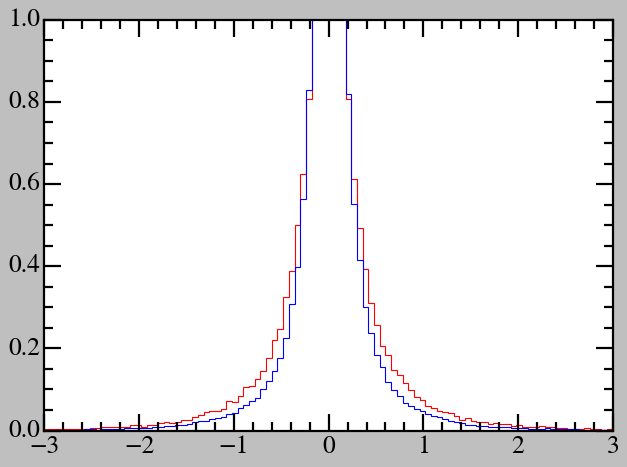

In [175]:
for pca_idx in range(16):
    print('PC', pca_idx+1)

    bins = np.linspace(-3,3,101)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]

    higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
    # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

    zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
    # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

    plt.xlim(-3,3)
    plt.ylim(0,1)

    plt.tight_layout()
    plt.show()